# Machine Learning  - Programming Assignment 2
## Real-world end-to-end ML deployment workflow: modeling, evaluation, UI design, and deployment

**Student Name:** SAI SRINIVAS KRISHNAN
 
**Email:** 2025aa05449@wilp.bits-pilani.ac.in  
**Student ID 2025AA05449**

**Date:** 23/01/2026

In [1]:
#Import all the necessary libraries
import numpy as np
import matplotlib.pyplot as mtp
import pandas as pd

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# xgboost
from xgboost import XGBClassifier

In [2]:
#Import the dataset
obesity_data_set_base = pd.read_csv(r'ObesityDataSet_raw.csv')
obesity_data = obesity_data_set_base

Shape: (2111, 17)
Columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']
Target variable: NObeyesdad


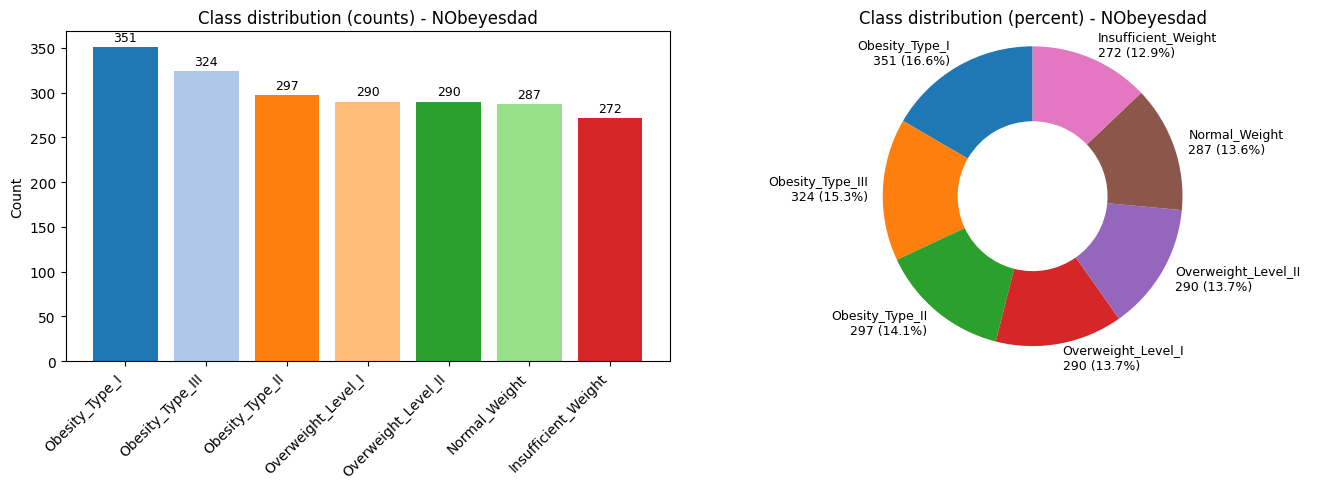

In [3]:
# Use the dataset already loaded in cell 2 if available; otherwise load from CSV
obesity_Fulldata_raw = obesity_data if 'obesity_data' in globals() else pd.read_csv(r'ObesityDataSet_raw.csv')

# Basic exploration
print("Shape:", obesity_Fulldata_raw.shape)
print("Columns:", list(obesity_Fulldata_raw.columns))

# Identify target variable
candidate_targets = [
    'NObeyesdad', 'NObesity', 'Obesity', 'Obesity_Level',
    'Obesity_Type', 'Obesity_Category', 'Obesity_Class',
    'class', 'target'
]
target_col = next((c for c in candidate_targets if c in obesity_Fulldata_raw.columns), None)
print("Target variable:", target_col if target_col else "Not found; please set manually")

if target_col:
    counts = obesity_Fulldata_raw[target_col].value_counts()
    labels = counts.index.tolist()
    sizes = counts.values

    fig, axes = mtp.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    axes[0].bar(labels, sizes, color=mtp.cm.tab20.colors[:len(labels)])
    axes[0].set_title(f'Class distribution (counts) - {target_col}')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=45, ha='right')
    for i, v in enumerate(sizes):
        axes[0].text(i, v + max(sizes) * 0.01, str(v), ha='center', va='bottom', fontsize=9)

    # Pie chart
    values = sizes
    total = values.sum()
    pie_labels = [f"{lab}\n{int(cnt)} ({cnt/total*100:.1f}%)" for lab, cnt in zip(labels, values)]
    axes[1].pie(values, labels=pie_labels, startangle=90, wedgeprops=dict(width=0.5), textprops={'fontsize':9})
    axes[1].set_title(f'Class distribution (percent) - {target_col}')
    axes[1].axis('equal')

    mtp.tight_layout()
    mtp.show()
else:
    print("Target column not found; cannot plot distribution.")



In [4]:
# reproducibility
np.random.seed(42)

# Separate features and target
FeaturesData = obesity_Fulldata_raw.drop(columns=[target_col])
target_classify = obesity_Fulldata_raw[target_col]

# Identify column types
categorical_cols = FeaturesData.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = FeaturesData.select_dtypes(include=[np.number]).columns.tolist()

# Pipelines for preprocessing
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer that applies the appropriate pipeline to each column group
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='drop'
)

# Train-test split (80-20), stratified for multiclass
Training_feature_set, Test_feature_set, raw_target_train, raw_target_test = train_test_split(
    FeaturesData, target_classify, test_size=0.2, random_state=42, stratify=target_classify
)

# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(raw_target_train)
y_test = label_encoder.transform(raw_target_test)

# Fit on train and transform both splits
X_train_processed = preprocessor.fit_transform(Training_feature_set)
X_test_processed = preprocessor.transform(Test_feature_set)

# ensure numpy arrays (in case transformers produce sparse)
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)
print("y_train shape:", y_train.shape)
print("Classes:", list(label_encoder.classes_))

X_train_processed shape: (1688, 31)
X_test_processed shape: (423, 31)
y_train shape: (1688,)
Classes: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss', verbosity=0, n_jobs=-1)
}

# Train all models and store them
trained_models = {}

print("Training models...")
print("=" * 60)

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_processed, y_train)
    trained_models[name] = model
    print(f"✓ {name} training complete")

print("=" * 60)
print(f"All {len(trained_models)} models trained successfully!")

Training models...
Training Logistic Regression...
✓ Logistic Regression training complete
Training Decision Tree...
✓ Decision Tree training complete
Training K-Nearest Neighbors...
✓ K-Nearest Neighbors training complete
Training Gaussian Naive Bayes...
✓ Gaussian Naive Bayes training complete
Training Random Forest...
✓ Random Forest training complete
Training XGBoost...
✓ XGBoost training complete
All 6 models trained successfully!


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate all trained models on test set
results = {}

for name, model in trained_models.items():
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'y_pred': y_pred
    }
    
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Summary comparison
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")
for name, result in results.items():
    print(f"{name:40s}: {result['accuracy']:.4f}")


Model: Logistic Regression
Accuracy: 0.8747

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      1.00      0.96        54
      Normal_Weight       0.81      0.74      0.77        58
     Obesity_Type_I       0.88      0.91      0.90        70
    Obesity_Type_II       0.94      0.97      0.95        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.74      0.74      0.74        58
Overweight_Level_II       0.81      0.76      0.79        58

           accuracy                           0.87       423
          macro avg       0.87      0.87      0.87       423
       weighted avg       0.87      0.87      0.87       423


Model: Decision Tree
Accuracy: 0.9149

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.87      0.91        54
      Normal_Weight       0.80      0.84      0.82        58
     Obesi

In [7]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import label_binarize

# Prepare binarized labels for multiclass AUC (One-vs-Rest)
n_classes = len(label_encoder.classes_)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Evaluate all models with comprehensive metrics
evaluation_results = []

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # AUC (One-vs-Rest, macro) - requires predict_proba
    auc_score = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test_processed)
            auc_score = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr', average='macro')
        except Exception:
            auc_score = None
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': acc,
        'AUC (OvR, macro)': auc_score if auc_score is not None else 'N/A',
        'Precision (macro)': prec,
        'Recall (macro)': rec,
        'F1 Score (macro)': f1,
        'MCC': mcc
    })

# Create DataFrame and sort by accuracy
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df_sorted = pd.DataFrame(evaluation_results).sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*100)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*100)
print(evaluation_df.to_string(index=False))
print("="*100)

print("="*100)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*100)
print(evaluation_df_sorted.to_string(index=False))
print("="*100)

COMPREHENSIVE MODEL EVALUATION
               Model  Accuracy  AUC (OvR, macro)  Precision (macro)  Recall (macro)  F1 Score (macro)      MCC
 Logistic Regression  0.874704          0.983363           0.870709        0.872421          0.870828 0.853869
       Decision Tree  0.914894          0.948826           0.915690        0.911831          0.913257 0.900713
 K-Nearest Neighbors  0.825059          0.964954           0.823496        0.818700          0.813140 0.798116
Gaussian Naive Bayes  0.508274          0.837216           0.520701        0.500220          0.451143 0.447055
       Random Forest  0.940898          0.994921           0.946391        0.939490          0.941226 0.931620
             XGBoost  0.952719          0.996544           0.953916        0.951201          0.951706 0.945066
COMPREHENSIVE MODEL EVALUATION
               Model  Accuracy  AUC (OvR, macro)  Precision (macro)  Recall (macro)  F1 Score (macro)      MCC
             XGBoost  0.952719          0.996544  

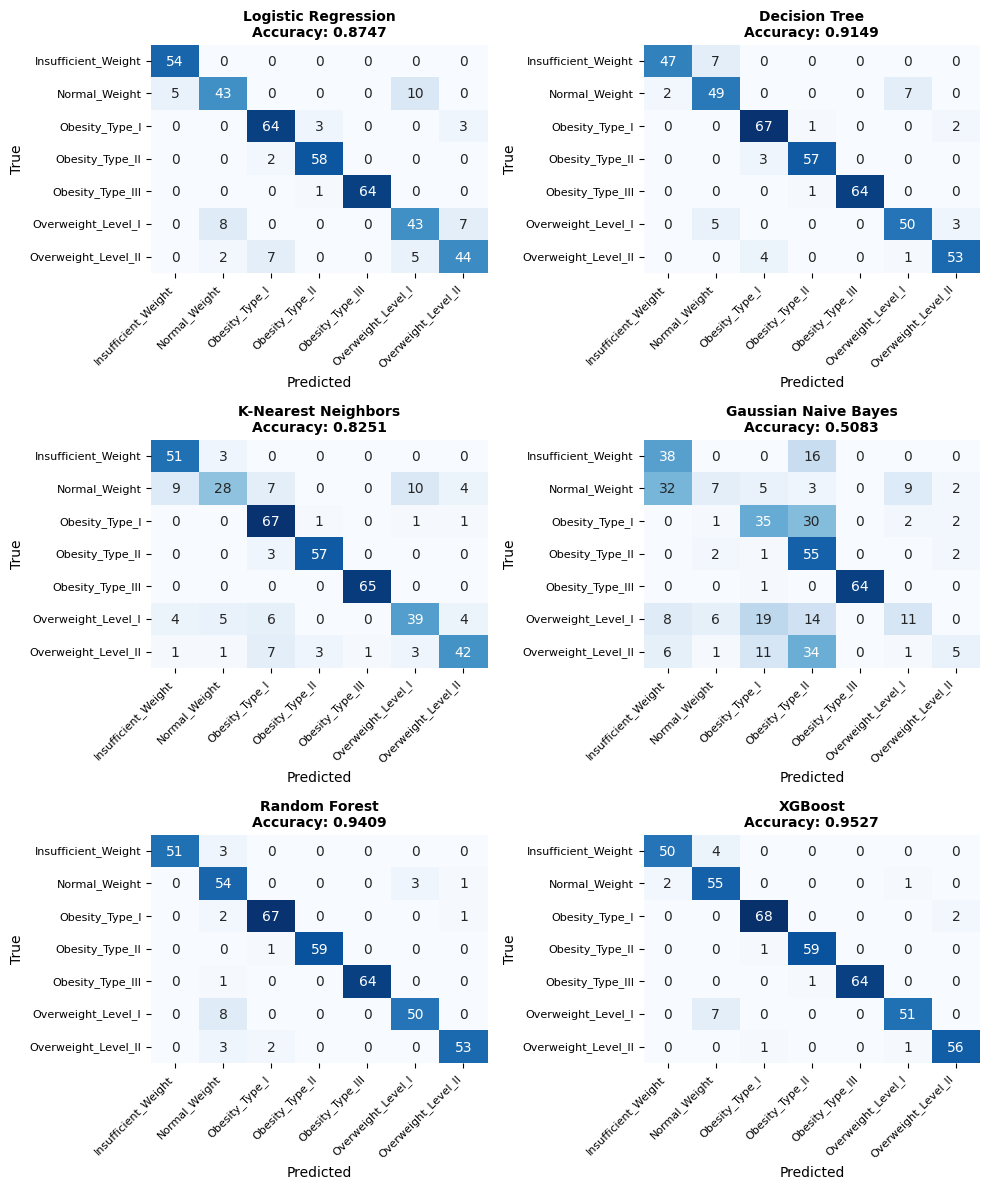

In [8]:
import seaborn as sns


def plot_confusion_matrix_ax(model, X_test, y_test, model_name, class_names, ax, vmax=None):
    """
    Plot confusion matrix on a provided Axes.
    Returns (cm, accuracy).
    """
    y_pred = model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    sns.heatmap(
        confusion_mat,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        vmax=vmax,
        cbar=False,
        ax=ax
    )
    ax.set_title(f"{model_name}\nAccuracy: {acc:.4f}", fontsize=10, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(class_names, rotation=0, fontsize=8)

    return confusion_mat, acc

# Prepare CMS and determine global vmax for consistent color scaling
model_items = list(trained_models.items())
cms = []
global_max = 0
for name, model in model_items:
    y_pred = model.predict(X_test_processed)
    confusion_mat = confusion_matrix(y_test, y_pred)
    cms.append((name, confusion_mat))
    global_max = max(global_max, confusion_mat.max())

# Grid layout
n_models = len(model_items)
cols = 2
rows = (n_models + cols - 1) // cols
fig, axes = mtp.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Plot each confusion matrix into grid
for i, (name, confusion_mat) in enumerate(cms):
    ax = axes[i]
    # get model instance from trained_models for accurate predictions & accuracy
    model = trained_models[name]
    plot_confusion_matrix_ax(model, X_test_processed, y_test, name, label_encoder.classes_, ax, vmax=global_max)

# Turn off any unused subplots
for j in range(n_models, len(axes)):
    axes[j].axis('off')

mtp.tight_layout()
mtp.show()


In [9]:
# Use the processed test set to get predictions from every trained model
# and attach decoded class labels to a DataFrame containing the original test rows.

# Generate decoded predictions for each model
predictions = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test_processed)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    predictions[name] = y_pred_labels

# Build a DataFrame with original test features, true label, and each model's predictions
pred_df = Test_feature_set.reset_index(drop=True).copy()
pred_df['true_label'] = label_encoder.inverse_transform(y_test)

for name, preds in predictions.items():
    pred_df[f'pred_{name}'] = preds

# Display a preview (first 20 rows). You can save pred_df or inspect further as needed.
pred_df.head(20)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,TUE,CALC,MTRANS,true_label,pred_Logistic Regression,pred_Decision Tree,pred_K-Nearest Neighbors,pred_Gaussian Naive Bayes,pred_Random Forest,pred_XGBoost
0,Female,19.084967,1.768435,49.597765,no,yes,3.000000,3.725797,Sometimes,no,...,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight
1,Male,19.000000,1.800000,60.000000,no,yes,2.000000,3.000000,Sometimes,no,...,1.000000,no,Public_Transportation,Normal_Weight,Insufficient_Weight,Normal_Weight,Normal_Weight,Insufficient_Weight,Normal_Weight,Normal_Weight
2,Male,24.108711,1.700000,80.761409,yes,yes,2.000000,3.000000,Sometimes,no,...,0.322405,Sometimes,Public_Transportation,Overweight_Level_II,Overweight_Level_II,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Overweight_Level_II,Overweight_Level_II
3,Female,20.941943,1.812963,138.730619,yes,yes,3.000000,3.000000,Sometimes,no,...,0.735201,Sometimes,Public_Transportation,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III
4,Male,33.293166,1.696412,103.250355,yes,yes,2.679664,2.415522,Sometimes,no,...,0.000000,no,Public_Transportation,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II
5,Female,23.474165,1.577115,78.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,0.000000,no,Public_Transportation,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I
6,Male,26.699317,1.839941,119.956651,yes,yes,2.244654,3.000000,Sometimes,no,...,0.000000,Sometimes,Public_Transportation,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II,Obesity_Type_II
7,Female,23.000000,1.650000,59.000000,no,no,3.000000,1.000000,Sometimes,no,...,2.000000,Sometimes,Public_Transportation,Normal_Weight,Normal_Weight,Normal_Weight,Overweight_Level_I,Insufficient_Weight,Normal_Weight,Normal_Weight
8,Female,43.591999,1.595165,77.354744,yes,yes,2.000000,3.000000,Sometimes,no,...,0.000000,no,Automobile,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I
9,Female,16.941489,1.551288,54.932420,no,yes,1.753750,1.296156,Sometimes,no,...,1.944675,Sometimes,Public_Transportation,Overweight_Level_I,Overweight_Level_I,Normal_Weight,Insufficient_Weight,Insufficient_Weight,Overweight_Level_I,Normal_Weight


In [10]:
# Compute comprehensive test metrics for all trained models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support, confusion_matrix, roc_auc_score,
    matthews_corrcoef
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

n_classes = len(label_encoder.classes_)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Containers for overall metrics and per-class metrics (kept separate)
metrics_list = []
per_class_list = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_processed)

    # overall metrics
    acc = accuracy_score(y_test, y_pred)
    prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    # per-class precision/recall/f1
    p_per, r_per, f_per, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=range(n_classes), zero_division=0
    )

    # AUC (OvR macro) if probabilities available
    auc_macro = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test_processed)
            auc_macro = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr', average='macro')
        except Exception:
            auc_macro = None

    confusion_mat = confusion_matrix(y_test, y_pred)

    # overall entry (no per-class columns here)
    entry = {
        "Model": name,
        "Accuracy": acc,
        "AUC (OvR, macro)": auc_macro,
        "Precision (macro)": prec_macro,
        "Recall (macro)": rec_macro,
        "F1 (macro)": f1_macro,
        "MCC": mcc,
        "ConfusionMatrix": confusion_mat
    }
    metrics_list.append(entry)

    # per-class rows (separate table)
    for ci, cls_name in enumerate(label_encoder.classes_):
        per_class_list.append({
            "Model": name,
            "Class": cls_name,
            "Precision": float(p_per[ci]),
            "Recall": float(r_per[ci]),
            "F1": float(f_per[ci])
        })

# Build DataFrames
metrics_df = pd.DataFrame(metrics_list)
per_class_df = pd.DataFrame(per_class_list)

# Keep ConfusionMatrix as last column for readability
if "ConfusionMatrix" in metrics_df.columns:
    cols = [c for c in metrics_df.columns if c != "ConfusionMatrix"] + ["ConfusionMatrix"]
    metrics_df = metrics_df[cols]

# Sort main metrics by F1 (macro) descending
metrics_df_sorted = metrics_df.sort_values("F1 (macro)", ascending=False).reset_index(drop=True)

# For convenience create a pivoted per-class F1 table (models x classes)
per_class_f1_pivot = per_class_df.pivot(index='Model', columns='Class', values='F1').reindex(metrics_df_sorted['Model'])

# Display summaries
pd.set_option("display.max_columns", None)
print("=== Models evaluation summary (sorted by F1 macro) ===")
display(metrics_df_sorted.drop(columns=["ConfusionMatrix"]))

print("\n=== Per-class F1 scores (pivoted: Model x Class) ===")
display(per_class_f1_pivot)

# Detailed reports for each model (classification report + confusion matrix)
for idx, row in metrics_df_sorted.iterrows():
    name = row["Model"]
    model = trained_models[name]
    print("\n" + "="*60)
    print(f"Model: {name}")
    print("-" * 60)
    y_pred = model.predict(X_test_processed)
    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_), zero_division=0))
    print("Confusion matrix:")
    print(row["ConfusionMatrix"])

# Optionally save to CSV (uncomment to enable)
# metrics_df_sorted.drop(columns=["ConfusionMatrix"]).to_csv("models_test_metrics_summary.csv", index=False)
# per_class_df.to_csv("models_per_class_metrics.csv", index=False)


=== Models evaluation summary (sorted by F1 macro) ===


,Model,Accuracy,"AUC (OvR, macro)",Precision (macro),Recall (macro),F1 (macro),MCC
0,XGBoost,0.952719,0.996544,0.953916,0.951201,0.951706,0.945066
1,Random Forest,0.940898,0.994921,0.946391,0.939490,0.941226,0.931620
2,Decision Tree,0.914894,0.948826,0.915690,0.911831,0.913257,0.900713
3,Logistic Regression,0.874704,0.983363,0.870709,0.872421,0.870828,0.853869
4,K-Nearest Neighbors,0.825059,0.964954,0.823496,0.818700,0.813140,0.798116
5,Gaussian Naive Bayes,0.508274,0.837216,0.520701,0.500220,0.451143,0.447055



=== Per-class F1 scores (pivoted: Model x Class) ===


Class,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Model,,,,,,,
XGBoost,0.943396,0.887097,0.971429,0.983333,0.992248,0.918919,0.965517
Random Forest,0.971429,0.837209,0.957143,0.991597,0.992248,0.900901,0.938053
Decision Tree,0.912621,0.823529,0.930556,0.957983,0.992248,0.862069,0.913793
Logistic Regression,0.955752,0.774775,0.895105,0.950820,0.992248,0.741379,0.785714
K-Nearest Neighbors,0.857143,0.589474,0.837500,0.942149,0.992366,0.702703,0.770642
Gaussian Naive Bayes,0.550725,0.186667,0.492958,0.518868,0.992248,0.271605,0.144928



Model: XGBoost
------------------------------------------------------------
Accuracy: 0.9527

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.93      0.94        54
      Normal_Weight       0.83      0.95      0.89        58
     Obesity_Type_I       0.97      0.97      0.97        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.88      0.92        58
Overweight_Level_II       0.97      0.97      0.97        58

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.96      0.95      0.95       423

Confusion matrix:
[[50  4  0  0  0  0  0]
 [ 2 55  0  0  0  1  0]
 [ 0  0 68  0  0  0  2]
 [ 0  0  1 59  0  0  0]
 [ 0  0  0  1 64  0  0]
 [ 0  7  0  0  0 51  0]
 [ 0  0  1  0  0  1 56]]

Model: Random Forest

<Figure size 1000x600 with 0 Axes>

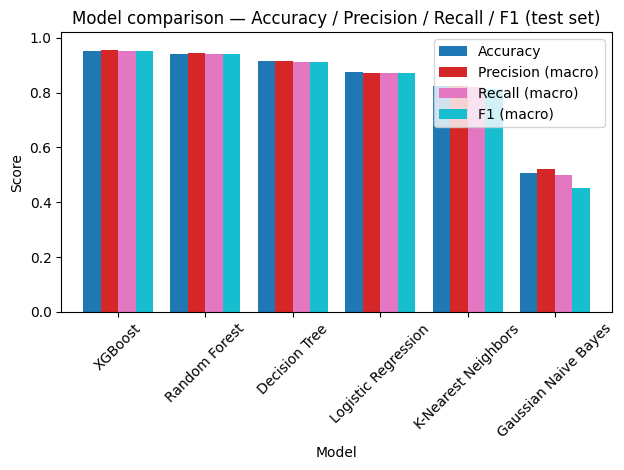

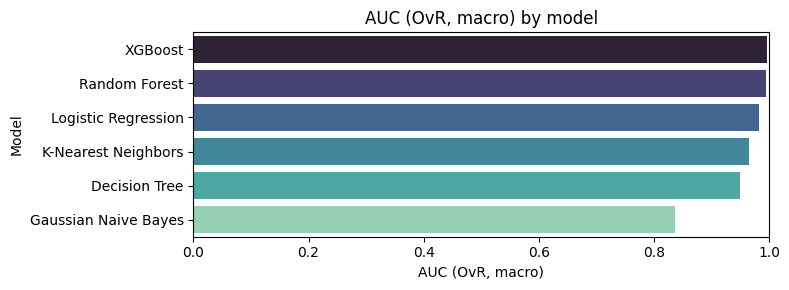

In [11]:
# Visualize test metrics (uses existing variables: metrics_df_sorted, sns, mtp, pd)
# Creates: grouped bar chart for key metrics, per-class F1 heatmap, and AUC barplot (if available)

# Guard: prefer metrics_df_sorted, fallback to metrics_df or evaluation_df if missing
df = None
if 'metrics_df_sorted' in globals():
    df = metrics_df_sorted.copy()
elif 'metrics_df' in globals():
    df = metrics_df.copy()
elif 'evaluation_df' in globals():
    df = evaluation_df.copy()
else:
    raise RuntimeError("No metrics DataFrame found (metrics_df_sorted / metrics_df / evaluation_df).")

# Ensure Model is present as column
if 'Model' not in df.columns:
    df = df.reset_index().rename(columns={df.index.name or 0: 'Model'})

# 1) Grouped bar chart for Accuracy / Precision / Recall / F1
metrics_cols = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
available_metrics = [c for c in metrics_cols if c in df.columns]

if available_metrics:
    plot_df = df[['Model'] + available_metrics].set_index('Model')
    mtp.figure(figsize=(10, 6))
    plot_df.plot(kind='bar', rot=45, colormap='tab10', width=0.8, legend=True)
    mtp.ylim(0, 1.02)
    mtp.title('Model comparison — Accuracy / Precision / Recall / F1 (test set)')
    mtp.ylabel('Score')
    mtp.tight_layout()
    mtp.show()
else:
    print("No key metrics (Accuracy/Precision/Recall/F1) found to plot.")


# 2) AUC (OvR, macro) barplot if numeric values present
if 'AUC (OvR, macro)' in df.columns:
    auc_df = df[['Model', 'AUC (OvR, macro)']].copy()
    auc_df['AUC_val'] = pd.to_numeric(auc_df['AUC (OvR, macro)'], errors='coerce')
    if auc_df['AUC_val'].notna().any():
        mtp.figure(figsize=(8, max(3, len(auc_df)*0.3)))
        ax = sns.barplot(
            data=auc_df.sort_values('AUC_val', ascending=False),
            x='AUC_val', y='Model', hue='Model', dodge=False, palette='mako'
        )
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        mtp.xlim(0, 1)
        mtp.title('AUC (OvR, macro) by model')
        mtp.xlabel('AUC (OvR, macro)')
        mtp.tight_layout()
        mtp.show()
    else:
        print("AUC column present but contains non-numeric values for all models.")
else:
    print("AUC (OvR, macro) column not found.")

In [12]:
import os
from joblib import dump
import json

# ensure folder exists
os.makedirs("model", exist_ok=True)

# Save each trained model to model/<name>.joblib
saved = []
for name, model in trained_models.items():
    fname = name.lower().replace(" ", "_").replace("-", "_")
    path = os.path.join("model", f"{fname}.joblib")
    dump(model, path)
    acc = None
    if 'results' in globals() and name in results:
        try:
            acc = float(results[name].get('accuracy', None))
        except Exception:
            acc = None
    saved.append({"model": name, "file": path, "accuracy": acc})

# Save preprocessing artifacts too (useful for inference)
if 'preprocessor' in globals():
    dump(preprocessor, os.path.join("model", "preprocessor.joblib"))
if 'label_encoder' in globals():
    dump(label_encoder, os.path.join("model", "label_encoder.joblib"))

# Save simple metadata for reference
meta_path = os.path.join("model", "models_metadata.json")
with open(meta_path, "w") as f:
    json.dump(saved, f, indent=2)

# Summary output
print("Saved models and artifacts to ./model")
for s in saved:
    acc_str = f" (accuracy={s['accuracy']:.4f})" if s['accuracy'] is not None else ""
    print(f"- {s['model']} -> {s['file']}{acc_str}")
print(f"- preprocessor -> ./model/preprocessor.joblib" if 'preprocessor' in globals() else "")
print(f"- label_encoder -> ./model/label_encoder.joblib" if 'label_encoder' in globals() else "")
print(f"- metadata -> {meta_path}")

Saved models and artifacts to ./model
- Logistic Regression -> model\logistic_regression.joblib (accuracy=0.8747)
- Decision Tree -> model\decision_tree.joblib (accuracy=0.9149)
- K-Nearest Neighbors -> model\k_nearest_neighbors.joblib (accuracy=0.8251)
- Gaussian Naive Bayes -> model\gaussian_naive_bayes.joblib (accuracy=0.5083)
- Random Forest -> model\random_forest.joblib (accuracy=0.9409)
- XGBoost -> model\xgboost.joblib (accuracy=0.9527)
- preprocessor -> ./model/preprocessor.joblib
- label_encoder -> ./model/label_encoder.joblib
- metadata -> model\models_metadata.json
